# Recruitment Challenge Dataiku
** Mohamed Al Ani **

16/05/2017

# Challenge

The following link lets you download an archive containing an “exercise” US Census dataset: http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip

This US Census dataset contains detailed but anonymized information for approximately 300,000 people.

The archive contains 3 files:
o A large learning .csv file
o Another test .csv file
o A metadata file describing the columns of the two above mentioned files (identical for both)

The goal of this exercise is to model the information contained in the last column (42nd), i.e., which people make more or less than $50,000 / year, from the information contained in the other columns. The exercise here consists of modeling a binary variable.

Work with R or Python to carry out the following steps:
- Import the learning and text files
- Based on the learning file:

- Make a quick statistic based and univariate audit of the different columns’ content and produce the results in visual / graphic format. This audit should describe the variable distribution, the % of missing values, the extreme values, and so on.
- Create a model using these variables (you can use whichever variables you want, or even create you own; for example, you could find the ratio or relationship between different variables, the one-hot encoding of “categorical” variables, etc.) to model wining more or less than $50,000 / year. Here, the idea would be for you to test one or two algorithms, such as logistic regression, or a decision tree. Feel free to choose others if wish.
- Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction.
- Apply your model to the test file and measure it’s real performance on it (same method as above).

The goal of this exercise is not to create the best or the purest model, but rather to describe the steps you took to accomplish it.

Explain areas that may have been the most challenging for you.

Find clear insights on the profiles of the people that make more than $50,000 / year. For example, which variables seem to be the most correlated with this phenomenon?

Finally, you push your code on GitHub to share it with me, or send it via email.

Once again, the goal of this exercise is not to solve this problem, but rather to spend a few hours on it and to thoroughly explain your approach. 

# Imports needed for the challenge

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing 
import itertools
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Some useful functions 

### Function for plotting a confusion matrix

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        cm = np.round(cm,2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)



    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Reading the CSV using pandas

In [54]:
#Dictionnary of variables that allows us to have a better understanding of the data
column_names_dict = {"AAGE": "age", 
        "ACLSWKR": "class of worker", #private / public
        "ADTIND" : "industry code",
        "ADTOCC" : "occupation code",
        "AHGA" : "education",
        "AHRSPAY" : "wage per hour",
        "AHSCOL" : "enrolled in edu inst last wk",
        "AMARITL" : "marital status",
        "AMJIND" : "major industry code",
        "AMJOCC" : "major occupation code", 
        "ARACE" : "race",
        "AREORGN" : "hispanic Origin",
        "ASEX" : "sex", 
        "AUNEM" : "member of a labor union",
        "AUNTYPE" : "reason for unemployment",
        "AWKSTAT" : "full or part time employment stat",
        "CAPGAIN" : "capital gains",
        "CAPLOSS" : "capital losses",
        "DIVVAL" : "divdends from stocks",
        "FILESTAT" : "tax filer status",   
        "GRINREG" : "region of previous residence",
        "GRINST" : "state of previous residence",
        "HHDFMX" : "detailed household and family stat",
        "HHDREL" :  "detailed household summary in household",
        "MAESUPWT" : "instance weight",
        "MIGMTR1" : "migration code-change in msa",
        "MIGMTR3" : "migration code-change in reg",
        "MIGMTR4" : "migration code-move within reg",
        "MIGSAME" : "live in this house 1 year ago",
        "MIGSUN" : "migration prev res in sunbelt",
        "NOEMP" : "num persons worked for employer",
        "PARENT" : "family members under 18",      
        "PEARNVAL" : "country of birth father",
        "PEMNTVTY" : "country of birth mother",
        "PENATVTY" : "country of birth self",
        "PRCITSHP" : "citizenship",
        "SEOTR" : "own business or self employed",
        "VETQVA" : "fill inc questionnaire for veteran's ",
        "VERYN" : "veterans benefits",
        "WKSWORK" : "weeks worked in year",
        "YEAR" : "year",
        "SALARY" : "salary"}

column_names = ["AAGE", "ACLSWKR", "ADTIND", "ADTOCC", "AHGA", "AHRSPAY", "AHSCOL",\
                "AMARITL", "AMJIND", "AMJOCC", "ARACE", "AREORGN", "ASEX", "AUNEMunion",\
                "AUNTYPE", "AWKSTAT", "CAPGAIN", "CAPLOSS", "DIVVAL", "FILESTAT",\
                "GRINREG", "GRINST", "HHDFMX", "HHDREL", "MAESUPWT", "MIGMTR1", "MIGMTR3",\
                "MIGMTR4", "MIGSAME", "MIGSUN", "NOEMP", "PARENT", "PEARNVAL", "PEMNTVTY",\
                "PENATVTY", "PRCITSHP", "SEOTR", "VETQVA", "VERYN", "WKSWORK", "YEAR", "SALARY"]

#Continuous and categorical variables will be treated differently 
continuous_var = ["AAGE", "AHRSPAY", "CAPGAIN", "CAPLOSS", "DIVVAL", "NOEMP", "WKSWORK", "MAESUPWT", "SALARY"]
nominal_var = [col for col in column_names if col not in continuous_var]       

In [345]:
train = pd.read_csv("us_census_full/census_income_learn.csv", names=column_names)
test = pd.read_csv("us_census_full/census_income_test.csv", names=column_names)

In [346]:
origin_train = train.copy()

# Some insights

### Datasets size 

In [56]:
print("train set : {} observations, {} variables".format(train.shape[0], train.shape[1]))
print("test set : {} observations, {} variables".format(test.shape[0], test.shape[1]))

train set : 199523 observations, 42 variables
test set : 99762 observations, 42 variables


Minimum working age in USA is 16 :

In [57]:
print(train[train["AAGE"]<16]["SALARY"].unique())

[' - 50000.']


### Description of continuous variables

In [58]:
train.ix[:, continuous_var].describe()

,AAGE,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,WKSWORK,MAESUPWT
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1.956180,23.174897,1740.380269
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,2.365126,24.411488,993.768156
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,37.870000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1061.615000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1.000000,8.000000,1618.310000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,4.000000,52.000000,2188.610000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,52.000000,18656.300000


We have some extreme values that we will need to get rid of

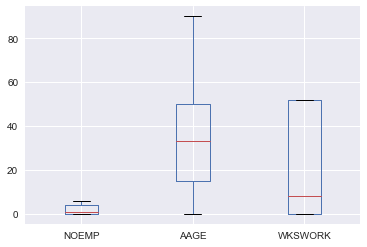

In [59]:
train.ix[:, ["NOEMP", "AAGE", "WKSWORK"]].plot.box()

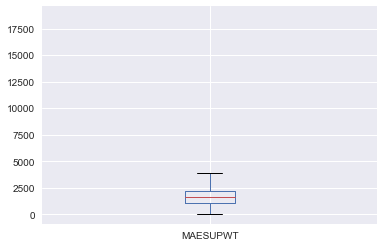

In [60]:
train.ix[:, ["MAESUPWT"]].plot.box()

C:\Users\Mohamed\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


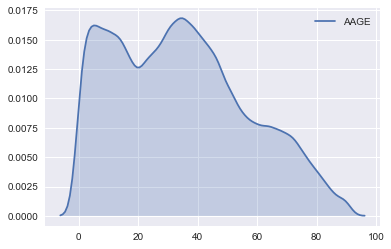

In [61]:
sns.kdeplot(train["AAGE"], shade=True)

Except for some, our continuous variables seem to have a very high variance that can be explained with extreme values. We will need to ignore aberrant data and standardize our continuous variables.

### Description of nominal variables

Number of categories for each nominal variables :

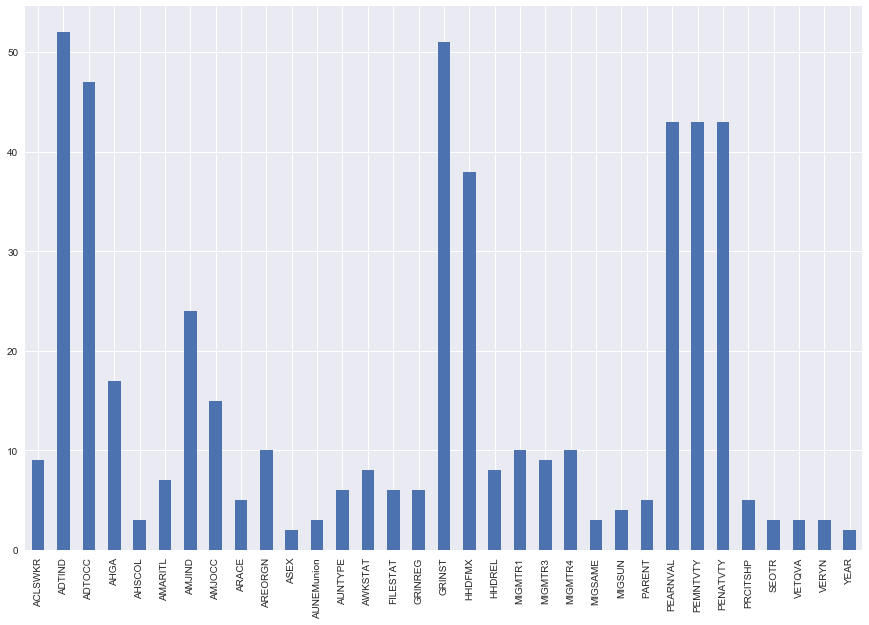

In [62]:
train.ix[:, [col for col in nominal_var if col!="MAESUPWT"]].apply(pd.Series.nunique).plot(kind="bar", figsize=(15,10))

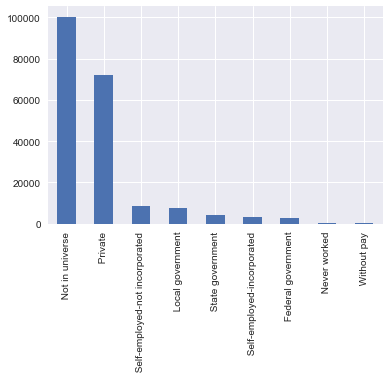

In [63]:
train["ACLSWKR"].value_counts().plot(kind='bar')

Our dataset has tons of "Not in universe" values but doesn't have any missing data. Test dataset also have "Not in Universe" values.

** Insights of Salary variable **

In [64]:
counts_salary = train["SALARY"].value_counts()

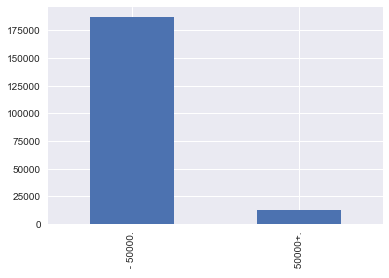

In [65]:
counts_salary.plot(kind='bar')

In [66]:
print("Percentage of > 50k salary : {:.2f}% ".format(counts_salary[1]*100 / (counts_salary[0] + counts_salary[1])))

Percentage of > 50k salary : 6.21% 


The dataset is strongly imbalanced, we need to keep that in mind and check the confusion matrix when we will start modelization. In that case of imbalanced dataset, the best thing to do is not using an accuracy scorer. AUC or f1-score take this information into account. However, since the challenge is "Kaggle-like" and since the goal is to have a better accuracy, we will use the accuracy scorer. We could also change the loss function to add a "weighted class" parameter.

# Some correlations and data relationships 

Let's first binarize our Salary variable for it to be easier to manipulate :

In [67]:
train["SALARY"] = train["SALARY"].map(lambda x : 0 if x==' - 50000.' else 1)
test["SALARY"] = test["SALARY"].map(lambda x : 0 if x==' - 50000.' else 1)

### Age differences 

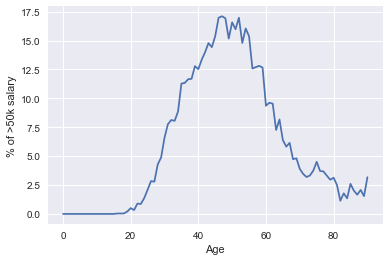

In [68]:
age_vs_salary = train.groupby("AAGE")["SALARY"].mean()
age_vs_salary = age_vs_salary.reset_index()
age_vs_salary.iloc[:,1]*=100
plt.plot(age_vs_salary["SALARY"])
plt.xlabel("Age")
plt.ylabel("% of >50k salary")

There seems to have a correlation between the age and the salary. People around 30-60 years old tend to earn way more money than others.

### Sex differences 

(array([0, 1]), <a list of 2 Text xticklabel objects>)

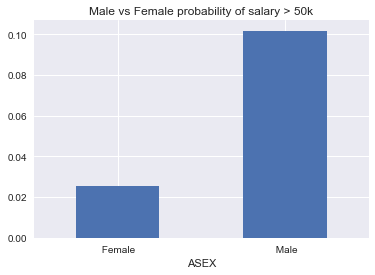

In [69]:
train.groupby("ASEX")["SALARY"].mean().plot(kind="bar")
plt.title("Male vs Female probability of salary > 50k")
plt.xticks(rotation=0)

Male tend to have a better salary than women (almost 10% of men have a salary > 50k for only 2.5% for women)

### Race differences

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

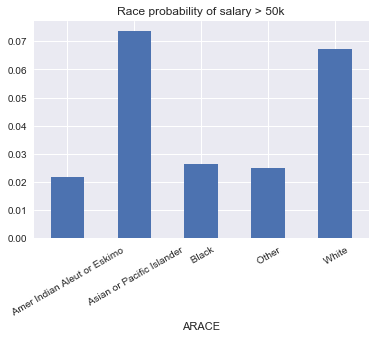

In [70]:
train.groupby("ARACE")["SALARY"].mean().plot(kind="bar")
plt.title("Race probability of salary > 50k")
plt.xticks(rotation=30)

### Continuous variables correlations 

In [362]:
origin_train["SALARY"] = origin_train["SALARY"].map(lambda x : 0 if x==' - 50000.' else 1)

In [363]:
corr_train = origin_train.corr()

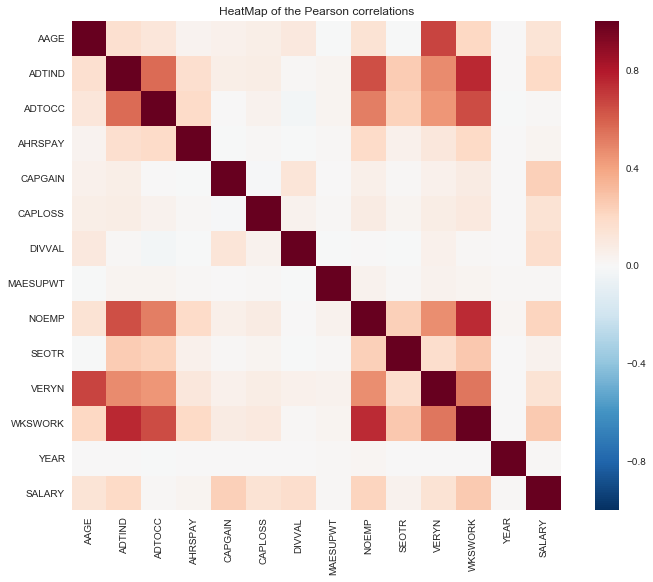

In [364]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corr_train, vmax=1, square=True)
plt.title("HeatMap of the Pearson correlations")
plt.show()

None of the variables seem strongly correlated. 

We won't try to calculate the correlations of the binary variables with the Salary variable as it will take too much time to calculate.

# Cleaning & Preprocessing

We get rid of extreme values that we managed to detect in the insights :

In [71]:
train = train[train["AHRSPAY"]!=9999]
train = train[train["CAPGAIN"]!=99999]
train = train[train["DIVVAL"]!=99999]

We standardScale our continuous variables. Fitting on the train and transforming the test dataset.  We however note that sclaing the data have no effect for linear models and tree ensemble methods.

In [72]:
ss = preprocessing.StandardScaler()
train.ix[:, [col for col in continuous_var if col!='SALARY']] = ss.fit_transform(train.ix[:, [col for col in continuous_var if col!='SALARY']])
test.ix[:, [col for col in continuous_var if col!='SALARY']] = ss.transform(test.ix[:, [col for col in continuous_var if col!='SALARY']])

Let's now create binary variables out of all our nominal variables : 

In [73]:
for var in nominal_var:
    dummies = pd.get_dummies(train[var], prefix=var)
    train = pd.concat([train, dummies], axis=1)
    train.drop(var, axis=1, inplace=True)

    dummies = pd.get_dummies(test[var], prefix=var)
    test = pd.concat([test, dummies], axis=1)
    test.drop(var, axis=1, inplace=True)

Let's check the dimensions :

In [74]:
print(train.shape, test.shape)

(199114, 512) (99762, 511)


One variable is contained in the train dataset but isn't in the test one, we get rid of it : 

In [75]:
for col in train.columns:
    if col not in list(test.columns):
        print("variable : ", col)
        train.drop(col, axis=1, inplace=True)

variable :  HHDFMX_ Grandchild <18 ever marr not in subfamily


Let's change our variable names so we don't have any space or special character in them : 

In [76]:
for var in train.columns:
    train.rename(columns={var:var.replace(" ", "_").replace(",", "").replace("[", "").replace("]", "").replace("<", "")}, inplace=True)
    test.rename(columns={var:var.replace(" ", "_").replace(",", "").replace("[", "").replace("]", "").replace("<", "")}, inplace=True)

We drop already binary variables

In [78]:
train.drop(["ASEX__Female", "YEAR_94"], axis=1, inplace=True)
test.drop(["ASEX__Female", "YEAR_94"], axis=1, inplace=True)

In [235]:
train.ix[:, continuous_var].head()

,AAGE,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,WKSWORK,MAESUPWT,SALARY
0,1.726339,-0.202281,-0.147083,-0.137324,-0.112903,-0.826059,-0.947654,-0.040487,0
1,1.054306,-0.202281,-0.147083,-0.137324,-0.112903,-0.403195,1.183098,-0.690980,0
2,-0.737782,-0.202281,-0.147083,-0.137324,-0.112903,-0.826059,-0.947654,-0.752956,0
3,-1.141002,-0.202281,-0.147083,-0.137324,-0.112903,-0.826059,-0.947654,0.017918,0
4,-1.096200,-0.202281,-0.147083,-0.137324,-0.112903,-0.826059,-0.947654,-0.675274,0


We create X and Y : 

In [79]:
train_X = train.drop("SALARY", axis=1)
train_Y = train["SALARY"]
test_X = test.drop("SALARY", axis=1)
test_Y = test["SALARY"]

Let's double check that we have the same number of variables : 

In [80]:
print(train_X.shape, test_X.shape)

(199114, 508) (99762, 508)


# Linear Models

### Logistic Regression

Let's first try out a classification with our raw data

In [96]:
%%time
#X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.33, random_state=42)
clf = LogisticRegression()
clf.fit(train_X, train_Y)
print(clf.score(test_X, test_Y))

0.953900282673
Wall time: 16.6 s


We will perform a feature selection using a cross validated recursive feature elimination  based on the values of the coefficients of the logistic regression. We use a step of 10 features so it won't take too much time to run :

In [105]:
%%time
# create the RFE model and select 3 attributes
rfe = RFECV(clf, step=10, cv=3, n_jobs=-1)
rfe = rfe.fit(train_X, train_Y)

Wall time: 9min 22s


Nomber of removed features : 90

In [107]:
print(np.sum(rfe.support_))

418


Let's rerun a Logistic Regression on our new table. 

In [106]:
clf = LogisticRegression()
clf.fit(train_X.iloc[:, rfe.support_], train_Y)
print(clf.score(test_X.iloc[:, rfe.support_], test_Y))


0.953860187246


In [111]:
print(classification_report(test_Y, clf.predict(test_X.iloc[:, rfe.support_])))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98     93576
          1       0.73      0.40      0.52      6186

avg / total       0.95      0.95      0.95     99762



Normalized confusion matrix
[[ 0.96  0.27]
 [ 0.04  0.73]]


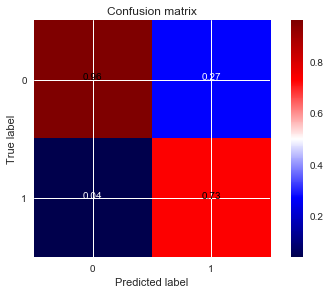

In [190]:
plot_confusion_matrix(confusion_matrix(test_Y, clf.predict(test_X)), classes=["0", "1"], normalize=True, title='Confusion matrix', cmap=plt.cm.seismic)

The model seems good with predicting salaries < 50k but kind of bad for salaries > 50k
This is due to the imbalanced dataset... tree-based models usually have good results with imbalanced datasets. Let's try that.

# Trees

### Random Forest

Let's first find quickly the best hyperparameters for a Random Forest. We will then check the feature importances of the model to perform a feature selection. We use RandomizedSearchCV for it to go faster.  

In [140]:
%%time
clf = RandomForestClassifier()

param_grid = {'n_estimators': [30, 35, 40],
             'max_depth' : [40, 50, 60, 70],
              "criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [2, 3]         
             }

rs = RandomizedSearchCV(clf, param_grid, cv=4, n_jobs=-1)
rs.fit(train_X, train_Y)

Wall time: 5min 49s


Let's print the best estimator we found : 

In [141]:
print(rs.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Now, we train our model an print the accuracy on the test set :

In [286]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

clf.fit(train_X, train_Y)
feat_importance = clf.feature_importances_

print(clf.score(test_X, test_Y))

0.954010545097


We use SelectFromModel to perform a feature selection. We use the basic threshold of 1e-5 to select the most significatives variables.

In [287]:
sfm = SelectFromModel(estimator=clf, prefit=True)
temp_tr = sfm.transform(train_X)
temp_te = sfm.transform(test_X)

New shape of our data : 

In [288]:
temp_tr.shape

(199114, 83)

In [291]:
support = sfm.get_support()

In [184]:
clf.fit(temp_tr, train_Y)
clf.score(temp_te, test_Y)

0.95527355105150258

The feature selection performed well, the accuracy seems higher.

Normalized confusion matrix
[[ 0.96  0.23]
 [ 0.04  0.77]]


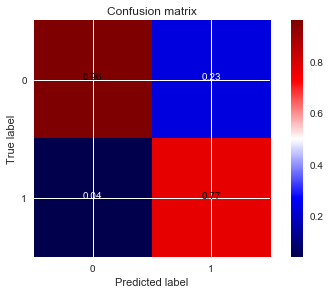

In [185]:
plot_confusion_matrix(confusion_matrix(test_Y, clf.predict(temp_te)), classes=["0", "1"], normalize=True, title='Confusion matrix', cmap=plt.cm.seismic)

We still have a bad estimator for 1 target.

### Extreme Gradient Boosting

We use Extreme Gradient Boosting better than Gradient Boosting so we can add regularization parameters and run our models on multiple jobs (I have 4 Cores so it will be way more faster)

We use a cross validated Grid Search to tune the hyper parameters and find the best estimator.

In [365]:
%%time
#We use the XGBClassifier that allows us to have a sklearn-like interface
model = XGBClassifier(silent=False)

param_grid = {'n_estimators': [160, 165, 170], #140, 150, 160: 160
              'max_depth' : [60, 70, 80], #70
              "learning_rate" : [0.03, 0.04, 0.05, 0.07], #0.05, 0.1, 0.2 : 0.05
              'min_child_weight' : [3], #4,5,6 :4
              'reg_alpha' : [7, 8, 9], #8, 10, 12 : 8
              'reg_lambda' : [0.6, 0.7, 0.8] #0.7
             }

rs = RandomizedSearchCV(model, param_grid, cv=3, n_jobs=-1)

rs.fit(temp_tr, train_Y)

Wall time: 1h 43min 56s


Best estimator :

In [366]:
rs.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=80,
       min_child_weight=3, missing=None, n_estimators=160, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=0.7,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [367]:
clf = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=80,
       min_child_weight=3, missing=None, n_estimators=160, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=0.7,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

clf.fit(temp_tr, train_Y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=80,
       min_child_weight=3, missing=None, n_estimators=160, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=0.7,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

New score on our test data : 

In [368]:
clf.score(temp_te, test_Y)

0.95747879954291215

Normalized confusion matrix
[[ 0.97  0.25]
 [ 0.03  0.75]]


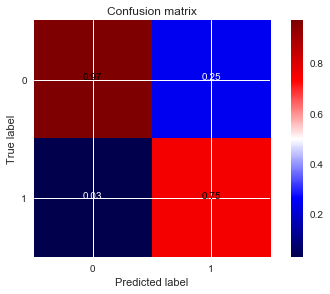

In [369]:
plot_confusion_matrix(confusion_matrix(test_Y, clf.predict(temp_te)), classes=["0", "1"], normalize=True, title='Confusion matrix', cmap=plt.cm.seismic)

# Most significative variables 

In [320]:
df_importance = pd.DataFrame(index=list(train.ix[:, support].columns), data=clf.feature_importances_, columns=[ "importance"])

** top 20 features by importance **

In [328]:
df_importance.sort_values(by="importance", ascending=False).head(20)

,importance
MAESUPWT,0.160977
AAGE,0.119383
DIVVAL,0.068358
CAPGAIN,0.039173
CAPLOSS,0.034332
NOEMP,0.033164
WKSWORK,0.027488
AHRSPAY,0.022967
AHGA__Less_than_1st_grade,0.018502
AMJIND__Entertainment,0.015260


Continuous variables seem to have been the most important features in our model. Maybe it's due to the fact that lots of categorical data were "not in universe".

The industry code was significative too, as well as education.

# Conclusion 

This Challenge was very interesting given the fact that the data was not easy to manipulate : lots of caterogical variables and 200k observations. We needed to reduce the number of variables. Feature engineering was not obvious as we had only 7 continuous variables. We could have implemented the variable "CAPGAIN" - "CAPLOSS" but this didn't bring any improvement. 

A second challenge was the imbalanced dataset. I chose to ignore the fact that our models didn't work so well for the target >50k salary and focus on the Accuracy, rather than the AUC score or f1_score as in the data description of the data set, accuracy scores were given. Taking a step back, I'm not so sure about this choice. I found that not-so-deep Random Forests managed to predict the "50k+" target quite well:


In [260]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
clf.fit(train_X, train_Y)
clf.score(test_X, test_Y)

print(classification_report(test_Y, clf.predict(test_X)))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     93576
          1       0.97      0.07      0.14      6186

avg / total       0.94      0.94      0.92     99762



We also could have used ACP for dimensionality reduction or even try out a LASSO.

To go further, we can try to tune a Neural Network that doesn't seem too bad : 

In [385]:
mlp = MLPClassifier(hidden_layer_sizes=(130), activation='logistic', verbose=True, tol=0.00001, learning_rate='constant', \
                    early_stopping=True, validation_fraction=0.2, solver='adam')
mlp.fit(train_X, train_Y)

Iteration 1, loss = 0.14921793
Validation score: 0.951460
Iteration 2, loss = 0.12308468
Validation score: 0.952364
Iteration 3, loss = 0.12138442
Validation score: 0.952565
Iteration 4, loss = 0.12108377
Validation score: 0.952138
Iteration 5, loss = 0.12063021
Validation score: 0.952515
Iteration 6, loss = 0.12029061
Validation score: 0.952615
Iteration 7, loss = 0.12011627
Validation score: 0.952716
Iteration 8, loss = 0.11966274
Validation score: 0.952992
Iteration 9, loss = 0.11937882
Validation score: 0.952590
Iteration 10, loss = 0.11903417
Validation score: 0.952766
Iteration 11, loss = 0.11829382
Validation score: 0.953218
Iteration 12, loss = 0.11769532
Validation score: 0.953243
Iteration 13, loss = 0.11717193
Validation score: 0.953494
Iteration 14, loss = 0.11655688
Validation score: 0.953645
Iteration 15, loss = 0.11596745
Validation score: 0.953921
Iteration 16, loss = 0.11540365
Validation score: 0.954222
Iteration 17, loss = 0.11493738
Validation score: 0.954549
Iterat

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=130, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-05, validation_fraction=0.2,
       verbose=True, warm_start=False)

In [386]:
mlp.score(test_X, test_Y)

0.95550409975742268